In [157]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [158]:
ticker = 'SPY'
data = yf.download(ticker)

[*********************100%***********************]  1 of 1 completed


In [159]:
df = data['Close']
df_no_index = df.copy().reset_index(drop = True)
period = 30 #Train test split test period
df

Date
1993-01-29     43.937500
1993-02-01     44.250000
1993-02-02     44.343750
1993-02-03     44.812500
1993-02-04     45.000000
                 ...    
2023-02-16    408.279999
2023-02-17    407.260010
2023-02-21    399.089996
2023-02-22    398.540009
2023-02-23    400.660004
Name: Close, Length: 7572, dtype: float64

In [125]:
Train, Test = df.iloc[:-period], df.iloc[-period:]

In [126]:
#TEST FOR STATIONARY DATA. ARIMA MODELS NEED STATIONARY DATA.

#AUGMENTED DICKEY-FULLER TEST:
dftest = adfuller(df['Close'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used,', 'Number of Obsevations Used'])
                     
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s) ' %key] = value

print(dfoutput)


Test Statistic                   0.633138
p-value                          0.988405
#Lags Used,                     36.000000
Number of Obsevations Used    7535.000000
Critical Value (1%)             -3.431218
Critical Value (5%)             -2.861924
Critical Value (10%)            -2.566974
dtype: float64


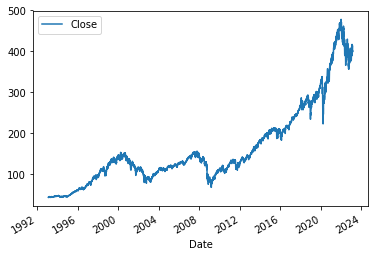

In [52]:
#Since p-value is greater than .05, this data is not stationary.
df.plot()

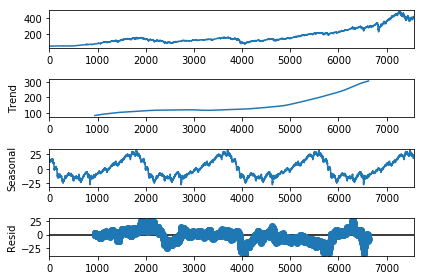

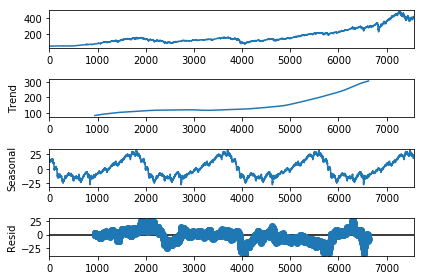

In [53]:
#Look at Residual, Seasonal, Trend view 
decompose_data = seasonal_decompose(df_no_index, model = "additive", period = int(len(df_no_index)/4))
decompose_data.plot()

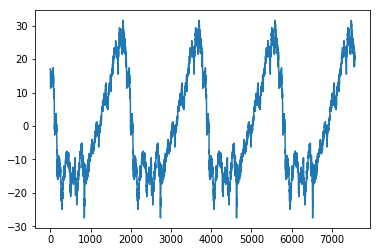

In [54]:
#Pull in specific chart if needed
decompose_data.seasonal.plot()

In [55]:
#Identifying D
#Here, we’ll use the KPSS test and ADF test, selecting the maximum value between the two to be conservative. 
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(Train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(Train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
#Estimated differencing term: 1


Estimated differencing term: 1


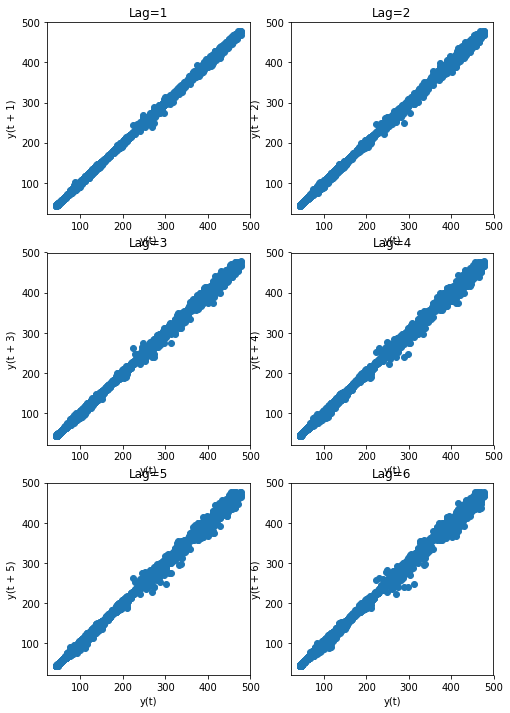

In [79]:
#As you may know, # an ARIMA model has 3 core hyper-parameters, known as “order”:

# p: The order of the auto-regressive (AR) model (i.e., the number of lag observations)
# d: The degree of differencing.
# q: The order of the moving average (MA) model. This is essentially the size of the “window” 
#     function over your time series data.

# Part of the science behind the auto-arima approach is intelligently finding the 
# proper combination of p, d, q such that you achieve the best fit. The TDS article took the approach of fixing the p
# parameter at 5 after examining auto-correlations with lag plots. 
# A lag plot can provide clues about the underlying structure of your data [1]:

#     A linear shape to the plot suggests that an autoregressive model is probably a better choice.
#     An elliptical plot suggests that the data comes from a single-cycle sinusoidal model.


from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(8, 12))
plt.title(ticker+' Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(Train, lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

#plt.show()
# As you can see, all the lags look fairly linear, so it’s a good indicator that an auto-regressive model 
# is a good choice. But since we don’t want to allow simple visual bias to impact our decision here, 
# we’ll allow the auto_arima to select the proper lag term for us

In [63]:
#Creating a pipeline to standerdize data (BoxCox) SARIMA include exogenous data
#Refer to Time Series Forecsting With Arima Sarima and Sarimax 
#https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6


pipeline = Pipeline([
    ("boxcox", BoxCoxEndogTransformer()),
    ("model", pm.AutoARIMA(start_p = 1,
                           start_q = 1,
                           test = 'adf',
                           max_p = 3,
                           max_q = 3,
                           m = 12, #frequency of cycle, using week of year, 12 for month
                           start_P = 0,
                           seasonal = True,
                           d = None,
                           D = n_diffs,#Order of the seasonal differencing
                           trace = False,
                           error_action = 'ignore',
                           suppress_warnings = True,
                           stepwise = True,
                           exogenous = Train.index.month
                           ))
])

pipe_model = pipeline.fit(Train)

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer()),
                ('model',
                 AutoARIMA(D=1, error_action='ignore', m=12, max_p=3, max_q=3,
                           start_P=0, start_p=1, start_q=1, test='adf'))])

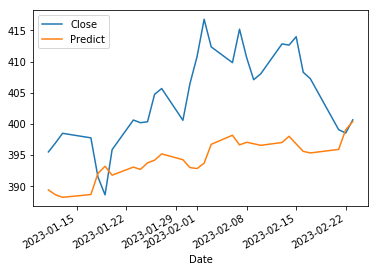

In [70]:
#Result using BoxCoXTransformer standardization in a pipeline
Pipe_Result = Test.copy()
Pipe_Result["Predict"] = pipeline.predict(period)
Pipe_Result.plot()

In [85]:
#Evaluate model, lower is better
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape



print(f"Mean squared error: {mean_squared_error(Test, Pipe_Result['Predict'])}")
print(f"SMAPE: {smape(Test, Pipe_Result['Predict'])}")

Mean squared error: 133.37517515697425
SMAPE: 2.5239096871705793


In [86]:
#SARIMA model using exogenouse factor (month) without standardization
Auto_Arima_model = pm.auto_arima(
                               Train,
                               exogenous = Train.index.month,
                               start_p = 1,
                               start_q = 1,
                               test = 'adf',
                               max_p = 3,
                               max_q = 3,
                               m = 12, #frequency of cycle, using week of year, 12 for month
                               start_P = 0,
                               seasonal = True,
                               d = None,
                               D = n_diffs,#Order of the seasonal differencing
                               trace = False,
                               error_action = 'ignore',
                               suppress_warnings = True,
                               stepwise = True
                                )

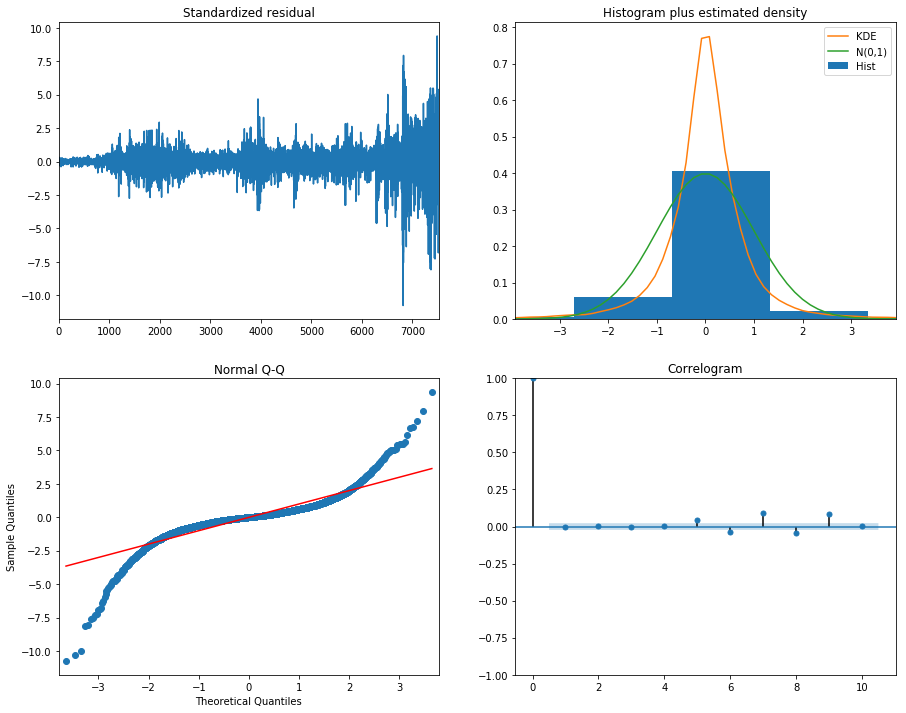

In [89]:
# Model Diagnostics

# Four plots result from the plot_diagnostics function. 
# The Standardized residual, Histogram plus KDE estimate, Normal q-q, and the correlogram.

# We can interpret the model as a good fit based on the following conditions.

# Standardized residual

# There are no obvious patterns in the residuals, with values
# having a mean of zero and having a uniform variance.

# Histogram plus KDE estimate

# The KDE curve should be very similar to the normal distribution 
# (labeled as N(0,1) in the plot)

# Normal Q-Q

# Most of the data points should lie on the straight line

# Correlogram (ACF plot)

# 95% of correlations for lag greater than zero should not be significant. 
# The grey area is the confidence band, and if values fall outside of this then they are statistically significant. 
# If there are a few values outside of this area, we may need to add more predictors to make the model more accurate
Auto_Arima_model.plot_diagnostics(figsize=(15,12))
plt.show()

C:\Users\Albert\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\Albert\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


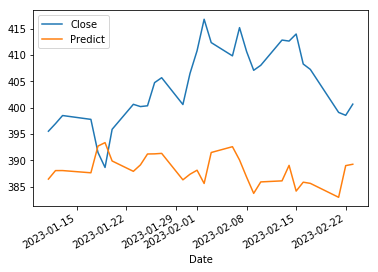

In [97]:
Auto_Arima_model.predict(period)
Result = Test.copy()
Result["Predict"] = pd.DataFrame(Auto_Arima_model.predict(period)).set_index(Result.index, drop = True)
Result.plot()




In [98]:
print(f"Mean squared error: {mean_squared_error(Test, Result['Predict'])}")
print(f"SMAPE: {smape(Test, Result['Predict'])}")

Mean squared error: 327.7977705508473
SMAPE: 4.131495450908167


In [100]:
#FInal THird model from http://alkaline-ml.com/pmdarima/usecases/stocks.html?highlight=mean%20squared%20error

auto = pm.auto_arima(Train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=33330.854, Time=5.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33386.687, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33333.684, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=33335.776, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33387.939, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=33335.201, Time=1.51 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=33293.716, Time=2.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=33333.371, Time=1.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=33333.399, Time=0.54 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=33331.400, Time=2.29 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=33334.593, Time=0.65 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=7.39 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=33295.685, Time=1.05 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 23.024 seconds


In [101]:
print(auto.order)

(2, 1, 1)


In [170]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto  # seeded from the model we've already fit
Test_series = Test['Close']
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in Test_series:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)
print(f"Mean squared error: {mean_squared_error(Test_series, forecasts)}")
print(f"SMAPE: {smape(Test_series, forecasts)}")

Mean squared error: 16.769264433721926
SMAPE: 0.834535124487563


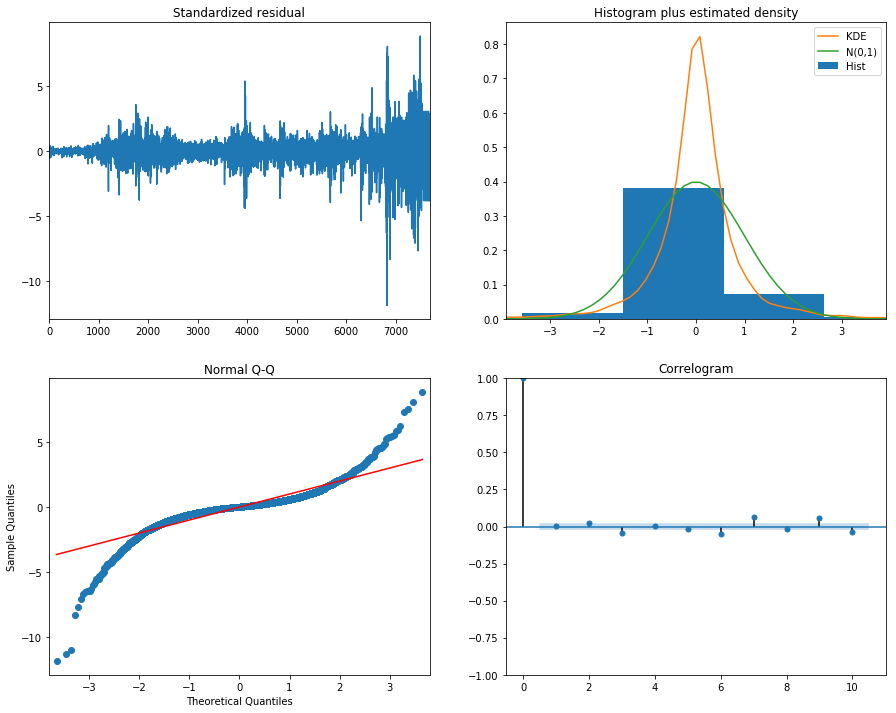

In [171]:
auto.plot_diagnostics(figsize=(15,12))
plt.show()

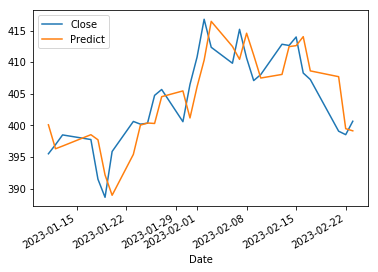

In [178]:
auto.predict(period)
Auto_Result = Test.copy()
Auto_Result["Predict"] = pd.DataFrame(forecasts).set_index(Auto_Result.index, drop = True)
Auto_Result.plot()
